# Import Requirements

In [1]:
from __future__ import division
import glob
import pandas as pd
import numpy as np
from scipy import stats
import itertools
from collections import Counter
import operator
import random
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# set fonts
mpl.rc('font',family='Arial')

# Import functions

In [2]:
def import_data(filepath):
    DF = pd.read_csv(filepath)
    C = ['Patient','Visit','DateOfVisit','Age','Gender','ART','VL','iVL','pVL',
     'CD4','iCD4','nCD4','CD8','iCD8','nCD8','TMHDS','VisitDate','GDS','Prot', 
     'AAPos','Coverage','A','R','N','D','C','Q','E','G','H','I','L','K','M',
     'F','P','S','T','W','Y','V']
    DF = DF[C]
    return DF

# Split into groups

In [3]:
DF = import_data('/Users/greg/Desktop/FullNeuroIllumina/MergedData/NGS_GDS_counts.csv')
DF1 = DF[DF['GDS']>=0.5]
DF2 = DF[DF['GDS']<0.5]
print DF.shape
print DF1.shape
print DF2.shape

(5608, 41)
(2977, 41)
(2631, 41)


In [4]:
# calculate diversity using a dictionary object as input
def diversity_column(counts, hill):
    vals = np.array(counts.values(), dtype=np.float64)
    vals /= vals.sum()
    if hill == 1:
        return np.exp(-np.sum(vals*np.log(vals)))
    else:
        return (vals**hill).sum()**(1/(1-hill))

# drop empty keys
def modify_dict(d):
    for k,v in d.items():
        if v == 0.0:
           del d[k]
    return d

def getIntrapatientDiversity(counts_df, hill_number):
    cols = ['A','R','N','D','C','Q','E','G','H','I',
            'L','K','M','F','P','S','T','W','Y','V']
    diversity_dict = {'Position':[], 'Diversity':[]}
    
    for i, g in counts_df.groupby('AAPos'):
        for j, row in g.iterrows():
            d = row[cols].to_dict()
            d2 = modify_dict(d)
            div = diversity_column(d2, hill_number)
            diversity_dict['Position'].append(i)
            diversity_dict['Diversity'].append(div)
            
    divDF = pd.DataFrame(diversity_dict)
    div_dict2 = {'Position':[], 'Mean Diversity':[], 'Std Diversity':[],
             'Minimum':[], 'Maximum':[], 'Distribution':[]}

    # information to return
    for i, g in divDF.groupby('Position'):
        div_dict2['Position'].append(int(i))
        div_dict2['Distribution'].append(list(g['Diversity']))
        div_dict2['Mean Diversity'].append(np.mean(g['Diversity']))
        div_dict2['Std Diversity'].append(np.std(g['Diversity']))
        div_dict2['Minimum'].append(min(g['Diversity']))
        div_dict2['Maximum'].append(max(g['Diversity']))
    divDF2 = pd.DataFrame(div_dict2)
    return divDF2

# Intrapatient Diversity Calculations

In [5]:
divDF = getIntrapatientDiversity(DF, 1)
divDF1 = getIntrapatientDiversity(DF1, 1)
divDF2 = getIntrapatientDiversity(DF2, 1)

In [6]:
for i in range(divDF1.shape[0]):
    L1 = divDF1['Distribution'].iloc[i]
    L2 = divDF2['Distribution'].iloc[i]
        
    t,p2 = stats.ttest_ind(L1, L2, equal_var=False)
    if p2 < 0.05:
        print 'T Test', i+1, p2

T Test 19 0.0291306321412
T Test 42 0.0436451063041
T Test 65 0.0158998725383


# Plot

In [7]:
def plot1(divDF, c1, c2, savepath):
    fig, ax = plt.subplots(figsize=(7,4))
    L = list(divDF['Mean Diversity'])
    L2 = [0] + L
    E = list(divDF['Std Diversity'])
    E2 = [0] + E

    y = np.array(L2)
    x = np.arange(len(L2))
    miny = y - np.array(E2)
    maxy = y + np.array(E2)

    # plot it
    ax.tick_params(axis='both',labelsize=14)
    ax.plot(x, y, linewidth=1.5, color=c1)
    #yerr = E2
    ax.fill_between(x, miny, maxy,facecolor=c2,alpha=0.1)
    ax.set_ylabel('Amino acid diversity',size=18, labelpad=10, weight='bold')
    ax.set_ylim([1,3])
    ax.set_xlabel('Tat amino acid position', size=18, labelpad=10, weight='bold')
    xs = [1,10,20,30,40,50,60,70,80,90,101]
    ax.set_xticks(xs)
    ax.set_xlim([1,101])

    ax.legend([mpl.patches.Patch(color=c1),
               mpl.patches.Patch(color=c2,alpha=0.1)],
               ['Mean intrapatient diversity', 'Standard deviation'],
               loc=1, ncol=1, fancybox=False, frameon=False,
               fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath, format='png', dpi=300, bbox_inches='tight')

/Users/greg/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


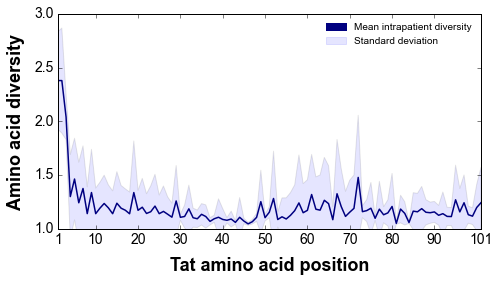

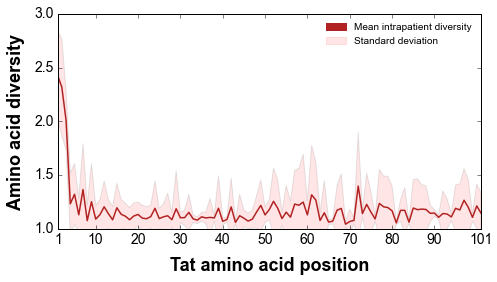

In [8]:
plot1(divDF1,'navy','blue','/Users/greg/Desktop/TatFigureStuff/Div/intra_impaired.png')
plot1(divDF2,'firebrick','red','/Users/greg/Desktop/TatFigureStuff/Div/intra_nonimpaired.png')

In [9]:
def plotCompare(divDF1, divDF2, savepath):
    fig, ax = plt.subplots(figsize=(7,4))
    LA = list(divDF1['Mean Diversity'])
    EA = list(divDF1['Std Diversity'])    
    LB = list(divDF2['Mean Diversity'])
    EB = list(divDF2['Std Diversity'])       
    L1 = [0] + LA
    E1 = [0] + EA
    L2 = [0] + LB
    E2 = [0] + EB

    x = np.arange(len(L1))
    y1 = np.array(L1)
    y2 = np.array(L2)
    miny1 = y1 - np.array(E1)
    maxy1 = y1 + np.array(E1)
    miny2 = y2 - np.array(E2)
    maxy2 = y2 + np.array(E2)

    # plot it
    ax.tick_params(axis='both',labelsize=14)
    ax.plot(x, y1, linewidth=1.5, color='navy')
    ax.plot(x, y2, linewidth=1.5, color='firebrick')
    
    ax.fill_between(x, miny1, maxy1,facecolor='blue',alpha=0.1)
    ax.fill_between(x, miny2, maxy2,facecolor='red',alpha=0.1)
    
    ax.set_ylabel('Amino acid diversity',size=18, labelpad=10, weight='bold')
    ax.set_ylim([1,3])
    ax.set_xlabel('Tat amino acid position', size=18, labelpad=10, weight='bold')
    xs = [1,10,20,30,40,50,60,70,80,90,101]
    ax.set_xticks(xs)
    ax.set_xlim([1,101])

    ax.legend([mpl.patches.Patch(color='navy'),
               mpl.patches.Patch(color='blue',alpha=0.1),
               mpl.patches.Patch(color='firebrick'),
               mpl.patches.Patch(color='red',alpha=0.1)],
               ['Mean impaired intrapatient diversity', 'Impaired standard deviation',
                'Mean non-impaired intrapatient diversity', 'Non-impaired standard deviation'],
               loc=1, ncol=1, fancybox=False, frameon=False,
               fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath, format='png', dpi=300, bbox_inches='tight')

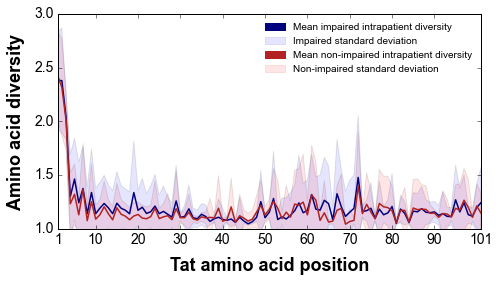

In [10]:
plotCompare(divDF1, divDF2, '/Users/greg/Desktop/TatFigureStuff/Div/intra_combined.png')

In [11]:
for i in [19,42,65]:
    print i, divDF1[divDF1['Position'] == i]['Mean Diversity']
    print i, divDF2[divDF2['Position'] == i]['Mean Diversity']

19 18    1.337017
Name: Mean Diversity, dtype: float64
19 18    1.118739
Name: Mean Diversity, dtype: float64
42 41    1.090908
Name: Mean Diversity, dtype: float64
42 41    1.20352
Name: Mean Diversity, dtype: float64
65 64    1.23409
Name: Mean Diversity, dtype: float64
65 64    1.062825
Name: Mean Diversity, dtype: float64


# Interpatient Diversity

In [12]:
def getInterDiversity(DF, divDF):
    cols = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    inter_intra_dict = {'Position':[], 'InterDiversity':[], 'IntraDiversity':[], 'Variants':[],'Total':[]}
    for i, g in DF.groupby('AAPos'):
        Alist = []
        for j, row in g.iterrows():
            d = row[cols].to_dict()
            d2 = modify_dict(d)
            div_round = int(round(diversity_column(d2, 1)))
            sorted_d = sorted(d2.items(), key=operator.itemgetter(1), reverse=True)
            top_variants = [var[0] for var in sorted_d[:div_round]]
            Alist += top_variants
        Adict = dict(Counter(Alist))
        sorted_Adict = sorted(Adict.items(), key=operator.itemgetter(1), reverse=True)
        Alist = [(x[0],x[1]) for x in sorted_Adict]
        inter_div = diversity_column(Adict, 1)
        intra_div = list(divDF[divDF['Position'] == int(i)]['Mean Diversity'])[0]

        # append to dictionary
        inter_intra_dict['Total'].append(g.shape[0])
        inter_intra_dict['Position'].append(int(i))
        inter_intra_dict['InterDiversity'].append(inter_div)
        inter_intra_dict['IntraDiversity'].append(intra_div)
        inter_intra_dict['Variants'].append(Alist)

    inter_intra_diversity_df = pd.DataFrame(inter_intra_dict)
    return inter_intra_diversity_df

In [13]:
varDF1 = getInterDiversity(DF1, divDF1)
varDF2 = getInterDiversity(DF2, divDF2)
varDF = getInterDiversity(DF, divDF)

In [276]:
varCompDF = pd.merge(varDF1, varDF2, left_on='Position', right_on='Position')
varCompDF['TotalInterDiversity'] = list(varDF['InterDiversity'])
varCompDF.to_csv('/Users/greg/Desktop/varCompDF.csv', index=False)

In [278]:
print varCompDF.shape
varCompDF.head()

(101, 10)


InterDiversity_x  IntraDiversity_x  Position  Total_x  \
0          3.707574          2.378747         1       29   
1          5.382381          2.378486         2       29   
2          2.363767          2.039296         3       29   
3          1.745985          1.299702         4       29   
4          2.158270          1.462926         5       29   

                                          Variants_x  InterDiversity_y  \
0  [(M, 28), (W, 24), (I, 5), (E, 3), (S, 2), (L,...          3.047378   
1  [(E, 24), (S, 19), (I, 7), (D, 6), (K, 4), (P,...          5.330095   
2                         [(P, 29), (Q, 25), (V, 3)]          2.161828   
3                  [(V, 29), (D, 3), (I, 1), (M, 1)]          1.461605   
4                  [(D, 29), (N, 5), (P, 3), (E, 1)]          1.809201   

   IntraDiversity_y  Total_y  \
0          2.427787       27   
1          2.316324       27   
2          2.008347       28   
3          1.232857       28   
4          1.321692       28   

                                          Variants_y  TotalInterDiversity  
0         [(M, 26), (W, 25), (I, 7), (S, 1), (E, 1)]             3.433133  
1  [(E, 21), (S, 17), (D, 7), (I, 5), (N, 3), (K,...             5.483579  
2                         [(P, 28), (Q, 25), (V, 1)]             2.273316  
3                          [(V, 28), (I, 2), (D, 1)]             1.637101  
4                          [(D, 27), (N, 6), (P, 1)]             2.018744

In [16]:
varCompDFx = varCompDF[varCompDF['TotalInterDiversity'] >= 1.5]
varCompDFx.to_csv('/Users/greg/Desktop/varCompDFx.csv')
print varCompDFx.shape
varCompDFx.head()

(52, 10)


InterDiversity_x  IntraDiversity_x  Position  Total_x  \
0          3.707574          2.378747         1       29   
1          5.382381          2.378486         2       29   
2          2.363767          2.039296         3       29   
3          1.745985          1.299702         4       29   
4          2.158270          1.462926         5       29   

                                          Variants_x  InterDiversity_y  \
0  [(M, 28), (W, 24), (I, 5), (E, 3), (S, 2), (L,...          3.047378   
1  [(E, 24), (S, 19), (I, 7), (D, 6), (K, 4), (P,...          5.330095   
2                         [(P, 29), (Q, 25), (V, 3)]          2.161828   
3                  [(V, 29), (D, 3), (I, 1), (M, 1)]          1.461605   
4                  [(D, 29), (N, 5), (P, 3), (E, 1)]          1.809201   

   IntraDiversity_y  Total_y  \
0          2.427787       27   
1          2.316324       27   
2          2.008347       28   
3          1.232857       28   
4          1.321692       28   

                                          Variants_y  TotalInterDiversity  
0         [(M, 26), (W, 25), (I, 7), (S, 1), (E, 1)]             3.433133  
1  [(E, 21), (S, 17), (D, 7), (I, 5), (N, 3), (K,...             5.483579  
2                         [(P, 28), (Q, 25), (V, 1)]             2.273316  
3                          [(V, 28), (I, 2), (D, 1)]             1.637101  
4                          [(D, 27), (N, 6), (P, 1)]             2.018744

# Plot Inter Diversity

In [17]:
def plotCompare2(divDF1, divDF2, varCompDF, savepath):
    fig, ax = plt.subplots(figsize=(7,4))
    LA = list(divDF1['Mean Diversity'])
    EA = list(divDF1['Std Diversity'])    
    LB = list(divDF2['Mean Diversity'])
    EB = list(divDF2['Std Diversity'])       
    L1 = [0] + LA
    E1 = [0] + EA
    L2 = [0] + LB
    E2 = [0] + EB
    
    C = list(varCompDF['InterDiversity_x'])
    D = list(varCompDF['InterDiversity_y'])
    F = list(varCompDF['TotalInterDiversity'])
    C1 = [0] + C
    D1 = [0] + D
    F1 = [0] + F

    x = np.arange(len(L1))
    y1 = np.array(L1)
    y2 = np.array(L2)
    y3 = np.array(C1)
    y4 = np.array(D1)
    y5 = np.array(F1)
    miny1 = y1 - np.array(E1)
    maxy1 = y1 + np.array(E1)
    miny2 = y2 - np.array(E2)
    maxy2 = y2 + np.array(E2)

    # plot it
    ax.tick_params(axis='both',labelsize=14)
    #ax.plot(x, y1, linewidth=1.5, color='navy')
    #ax.plot(x, y2, linewidth=1.5, color='firebrick')
    ax.plot(x, y3, linewidth=1.5, color='navy',alpha=0.5)
    ax.plot(x, y4, linewidth=1.5, color='firebrick',alpha=0.5)
    ax.plot(x, y5, linewidth=1.5, color='black', ls='--',alpha=0.5)
    
    #ax.fill_between(x, miny1, maxy1,facecolor='blue',alpha=0.1)
    #ax.fill_between(x, miny2, maxy2,facecolor='red',alpha=0.1)
    
    ax.set_ylabel('Amino acid diversity',size=18, labelpad=10, weight='bold')
    ax.set_ylim([1,7])
    ax.set_xlabel('Tat amino acid position', size=18, labelpad=10, weight='bold')
    xs = [1,10,20,30,40,50,60,70,80,90,101]
    ax.set_xticks(xs)
    ax.set_xlim([1,101])

    ax.legend([mpl.patches.Patch(color='navy',alpha=0.5),
               mpl.patches.Patch(color='firebrick',alpha=0.5),
               mpl.patches.Patch(color='black',alpha=0.5)],
               ['Impaired interpatient diversity', 'Non-impaired interpatient diversity',
                'Total interpatient diversity'],
               loc=1, ncol=1, fancybox=False, frameon=False,
               fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath, format='png', dpi=300, bbox_inches='tight')

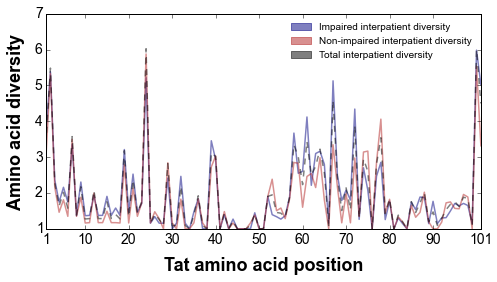

In [18]:
plotCompare2(divDF1, divDF2, varCompDF, '/Users/greg/Desktop/TatFigureStuff/Div/inter_combined.png')

# Scatterplot

0.198156315827


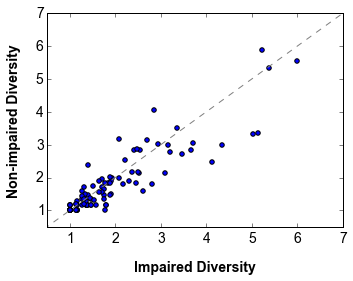

In [20]:
fig,ax = plt.subplots(figsize=(5,4))
x = varCompDF['InterDiversity_x']
y = varCompDF['InterDiversity_y']

dx = np.arange(len(x))
dy = np.arange(len(x))
ax.scatter(x,y)
ax.plot(dx,dy,color='gray',ls='--')

ax.set_xlim([0.5,7])
ax.set_ylim([0.5,7])

ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Impaired Diversity', weight='bold', fontsize=14, labelpad=15)
ax.set_ylabel('Non-impaired Diversity', weight='bold', fontsize=14, labelpad=15)

u,p = stats.mannwhitneyu(x,y)
print p

plt.tight_layout()
plt.show()

# Enrichment

In [64]:
print varCompDF.shape
varCompDF.head()

(101, 10)


InterDiversity_x  IntraDiversity_x  Position  Total_x  \
0          3.707574          2.378747         1       29   
1          5.382381          2.378486         2       29   
2          2.363767          2.039296         3       29   
3          1.745985          1.299702         4       29   
4          2.158270          1.462926         5       29   

                                          Variants_x  InterDiversity_y  \
0  [(M, 28), (W, 24), (I, 5), (E, 3), (S, 2), (L,...          3.047378   
1  [(E, 24), (S, 19), (I, 7), (D, 6), (K, 4), (P,...          5.330095   
2                         [(P, 29), (Q, 25), (V, 3)]          2.161828   
3                  [(V, 29), (D, 3), (I, 1), (M, 1)]          1.461605   
4                  [(D, 29), (N, 5), (P, 3), (E, 1)]          1.809201   

   IntraDiversity_y  Total_y  \
0          2.427787       27   
1          2.316324       27   
2          2.008347       28   
3          1.232857       28   
4          1.321692       28   

                                          Variants_y  TotalInterDiversity  
0         [(M, 26), (W, 25), (I, 7), (S, 1), (E, 1)]             3.433133  
1  [(E, 21), (S, 17), (D, 7), (I, 5), (N, 3), (K,...             5.483579  
2                         [(P, 28), (Q, 25), (V, 1)]             2.273316  
3                          [(V, 28), (I, 2), (D, 1)]             1.637101  
4                          [(D, 27), (N, 6), (P, 1)]             2.018744

# Define functions

In [70]:
def makeCdict(Cdict, S, x, y, tx, ty, p):
    for s in S:
        if s in x.keys():
            vx = x[s]
        else:
            vx = 0   
        if s in y.keys():
            vy = y[s]
        else:
            vy = 0
        Cdict['Position'].append(p)
        Cdict['Variant'].append(s)
        Cdict['Count1'].append(vx)
        Cdict['Count2'].append(vy)
        Cdict['Total1'].append(tx)
        Cdict['Total2'].append(ty)
    return Cdict

def processCdict(Cdict):
    Cdf = pd.DataFrame(Cdict)
    Cdf = Cdf[['Position','Variant','Count1','Count2','Total1','Total2']]
    Cdf['Proportion1'] = Cdf['Count1']/Cdf['Total1']
    Cdf['Proportion2'] = Cdf['Count2']/Cdf['Total2']
    Cdf['Difference'] = Cdf['Proportion1'] - Cdf['Proportion2']
    Cdf['Count'] = Cdf['Count1'] + Cdf['Count2']
    Cdf['Total'] = Cdf['Total1'] + Cdf['Total2']
    Cdf['Proportion'] = (Cdf['Count'] / Cdf['Total'])*100
    return Cdf

def loopCode(varCompDF, Cdict):
    for i, row in varCompDF.iterrows():
        p = row['Position']
        tx = row['Total_x']
        ty = row['Total_y']
        x = dict(row['Variants_x'])
        y = dict(row['Variants_y'])
        l1 = [a[0] for a in row['Variants_x']]
        l2 = [b[0] for b in row['Variants_y']]
        S = list(set(list(l1) + list(l2)))
        Cdict = makeCdict(Cdict, S, x, y, tx, ty, p)
    return Cdict

def cleanCdf(Cdf):
    Cdf_exclusive1 = Cdf[Cdf['Count1'] == 0]
    Cdf_exclusive2 = Cdf[Cdf['Count2'] == 0]
    Cdf_drop = Cdf[Cdf.Count1 != 0]
    Cdf_drop = Cdf_drop[Cdf_drop.Count2 != 0]
    Cdf_drop['Log2FC'] = abs(np.log2(Cdf_drop['Proportion1'] / Cdf_drop['Proportion2']))
    return Cdf_exclusive1, Cdf_exclusive2, Cdf_drop

In [73]:
Cdict = {'Position':[], 'Variant':[], 'Count1':[], 'Count2':[],
         'Total1':[], 'Total2':[]}
Cdict = loopCode(varCompDF, Cdict)
Cdf = processCdict(Cdict)
Cdf_exclusive1, Cdf_exclusive2, Cdf_drop = cleanCdf(Cdf)
Cdf_drop.head()

Position Variant  Count1  Count2  Total1  Total2  Proportion1  Proportion2  \
0         1       E       3       1      29      27     0.103448     0.037037   
1         1       I       5       7      29      27     0.172414     0.259259   
2         1       M      28      26      29      27     0.965517     0.962963   
5         1       S       2       1      29      27     0.068966     0.037037   
6         1       W      24      25      29      27     0.827586     0.925926   

   Difference  Count  Total  Proportion    Log2FC  
0    0.066411      4     56    7.142857  1.481869  
1   -0.086845     12     56   21.428571  0.588520  
2    0.002554     54     56   96.428571  0.003822  
5    0.031928      3     56    5.357143  0.896907  
6   -0.098340     49     56   87.500000  0.161987

# Exclusive

In [293]:
Cdf_exclusive1.sort_values(by='Proportion2',ascending=False, inplace=True)
ex1 = Cdf_exclusive1[Cdf_exclusive1['Count2']>2]
ex1

/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Position Variant  Count1  Count2  Total1  Total2  Proportion1  \
195        59       H       0       7      28      27            0   
100        24       S       0       4      28      28            0   
296        79       K       0       3      32      23            0   
365        98       T       0       3      32      23            0   
172        53       K       0       3      29      28            0   

     Proportion2  Difference  Count  Total  Proportion  
195     0.259259   -0.259259      7     55   12.727273  
100     0.142857   -0.142857      4     56    7.142857  
296     0.130435   -0.130435      3     55    5.454545  
365     0.130435   -0.130435      3     55    5.454545  
172     0.107143   -0.107143      3     57    5.263158

In [294]:
Cdf_exclusive2.sort_values(by='Proportion1',ascending=False, inplace=True)
ex2 = Cdf_exclusive2[Cdf_exclusive2['Count1']>2]
ex2

/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Position Variant  Count1  Count2  Total1  Total2  Proportion1  \
234        65       N       6       0      29      26     0.206897   
212        61       S       3       0      28      26     0.107143   
203        60       P       3       0      28      26     0.107143   
352        95       N       3       0      32      23     0.093750   
333        90       G       3       0      32      23     0.093750   

     Proportion2  Difference  Count  Total  Proportion  
234            0    0.206897      6     55   10.909091  
212            0    0.107143      3     54    5.555556  
203            0    0.107143      3     54    5.555556  
352            0    0.093750      3     55    5.454545  
333            0    0.093750      3     55    5.454545

# Permutation Tests

In [185]:
print Cdf_drop.shape
Cdf_drop.head()

(242, 13)


Position Variant  Count1  Count2  Total1  Total2  Proportion1  Proportion2  \
0         1       E       3       1      29      27     0.103448     0.037037   
1         1       I       5       7      29      27     0.172414     0.259259   
2         1       M      28      26      29      27     0.965517     0.962963   
5         1       S       2       1      29      27     0.068966     0.037037   
6         1       W      24      25      29      27     0.827586     0.925926   

   Difference  Count  Total  Proportion    Log2FC  
0    0.066411      4     56    7.142857  1.481869  
1   -0.086845     12     56   21.428571  0.588520  
2    0.002554     54     56   96.428571  0.003822  
5    0.031928      3     56    5.357143  0.896907  
6   -0.098340     49     56   87.500000  0.161987

In [195]:
permut_dict = {'Position':[], 'Variant':[], 'Random1':[], 'Random2':[]}

ttt=0
for i,group in Cdf_drop.groupby('Position'):
    v = list(group['Variant'])
    c1,c2 = list(group['Count1']), list(group['Count2'])
    X,Y = zip(v,c1), zip(v,c2)
    x,y = '',''
    for item in X:
        x = x + item[0]*item[1]
    for item in Y:
        y = y + item[0]*item[1]
    Z = x+y
    Zlist = list(Z)
    Zkeys = dict(Counter(Zlist)).keys()
    #print i,Zkeys,len(Zlist), len(x), len(y)
    
    M1 = []
    M2 = []
    for j in range(10000):
        Zscramble = Zlist[:]
        random.shuffle(Zscramble)
        ZS1, ZS2 = Zscramble[:len(x)], Zscramble[len(x):]
        #print len(Zscramble), len(ZS1), len(ZS2)
        Counter1, Counter2 = Counter(ZS1), Counter(ZS2)        
        M1.append(Counter1)
        M2.append(Counter2)
    
    for k in Zkeys:       
        M1tally = []
        M2tally = []
        for m in M1:
            M1tally.append(m[k])
        for m in M2:
            M2tally.append(m[k])
        #print i,k, len(M1tally), len(M2tally)
        permut_dict['Position'].append(i)
        permut_dict['Variant'].append(k)
        permut_dict['Random1'].append(M1tally)
        permut_dict['Random2'].append(M2tally)
        ttt+=1

permut_DF = pd.DataFrame(permut_dict)
permut_DF

Position                                            Random1  \
0           1  [5, 7, 6, 6, 7, 9, 5, 7, 6, 8, 9, 6, 7, 7, 4, ...   
1           1  [0, 2, 3, 1, 3, 3, 0, 2, 1, 3, 3, 1, 2, 3, 3, ...   
2           1  [1, 1, 3, 1, 2, 1, 3, 3, 1, 2, 0, 1, 1, 1, 1, ...   
3           1  [27, 28, 29, 26, 31, 24, 28, 23, 29, 26, 25, 2...   
4           1  [29, 24, 21, 28, 19, 25, 26, 27, 25, 23, 25, 2...   
5           2  [19, 20, 27, 22, 23, 27, 27, 25, 23, 30, 22, 2...   
6           2  [8, 10, 7, 7, 8, 8, 5, 6, 8, 8, 8, 10, 7, 5, 1...   
7           2  [7, 5, 7, 8, 6, 5, 7, 5, 7, 5, 7, 2, 8, 9, 5, ...   
8           2  [4, 1, 3, 4, 2, 2, 2, 5, 2, 4, 2, 5, 2, 3, 3, ...   
9           2  [1, 1, 4, 3, 4, 2, 3, 1, 3, 1, 2, 1, 1, 1, 2, ...   
10          2  [2, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, ...   
11          2  [3, 3, 0, 3, 1, 3, 1, 2, 4, 1, 1, 3, 1, 2, 3, ...   
12          2  [21, 23, 17, 18, 20, 16, 20, 19, 18, 16, 23, 2...   
13          3  [25, 27, 26, 24, 28, 27, 23, 28, 29, 26, 26, 2...   
14          3  [29, 28, 30, 29, 27, 28, 32, 28, 26, 29, 29, 2...   
15          3  [3, 2, 1, 4, 2, 2, 2, 1, 2, 2, 2, 1, 3, 3, 2, ...   
16          4  [3, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 3, 0, 2, 1, ...   
17          4  [3, 2, 2, 4, 2, 2, 1, 2, 3, 1, 3, 3, 3, 2, 2, ...   
18          4  [27, 30, 29, 28, 29, 29, 31, 30, 28, 32, 28, 2...   
19          5  [4, 0, 2, 2, 3, 2, 1, 1, 2, 1, 1, 3, 1, 1, 2, ...   
20          5  [29, 31, 28, 32, 28, 29, 30, 30, 26, 29, 31, 3...   
21          5  [4, 6, 7, 3, 6, 6, 6, 6, 9, 7, 5, 2, 8, 5, 3, ...   
22          6  [29, 28, 29, 28, 29, 32, 30, 30, 30, 29, 30, 2...   
23          6  [2, 3, 2, 4, 3, 1, 2, 3, 2, 3, 2, 3, 3, 2, 2, ...   
24          6  [2, 2, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...   
25          7  [4, 3, 1, 2, 4, 0, 2, 4, 3, 3, 2, 2, 4, 3, 2, ...   
26          7  [6, 7, 7, 7, 6, 9, 6, 5, 5, 5, 8, 7, 6, 7, 4, ...   
27          7  [18, 22, 20, 22, 21, 23, 24, 21, 22, 21, 20, 2...   
28          7  [6, 3, 6, 5, 3, 3, 4, 6, 4, 5, 5, 4, 4, 3, 9, ...   
29          7  [3, 2, 3, 1, 3, 2, 1, 1, 3, 3, 2, 4, 3, 1, 2, ...   
..        ...                                                ...   
212        89  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...   
213        90  [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...   
214        91  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...   
215        92  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...   
216        93  [29, 31, 29, 31, 29, 29, 31, 30, 30, 31, 29, 2...   
217        93  [3, 1, 3, 1, 3, 3, 1, 2, 2, 1, 3, 3, 2, 3, 2, ...   
218        94  [3, 4, 2, 2, 2, 3, 2, 3, 1, 1, 4, 1, 1, 2, 2, ...   
219        94  [28, 27, 29, 29, 29, 28, 29, 28, 30, 30, 27, 3...   
220        95  [29, 28, 30, 30, 29, 29, 30, 29, 28, 28, 32, 2...   
221        95  [3, 4, 2, 2, 3, 3, 2, 3, 4, 4, 0, 4, 3, 1, 4, ...   
222        96  [4, 2, 2, 2, 1, 2, 2, 3, 4, 3, 3, 4, 2, 2, 2, ...   
223        96  [27, 29, 29, 28, 30, 28, 28, 27, 26, 27, 28, 2...   
224        96  [1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, ...   
225        97  [30, 28, 28, 27, 29, 28, 30, 29, 29, 31, 31, 3...   
226        97  [4, 6, 6, 7, 5, 6, 4, 5, 5, 3, 3, 4, 6, 4, 4, ...   
227        98  [28, 31, 27, 27, 30, 29, 28, 28, 27, 29, 30, 2...   
228        98  [4, 1, 5, 5, 2, 3, 4, 4, 5, 3, 2, 5, 2, 5, 4, ...   
229        99  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...   
230       100  [3, 1, 2, 2, 0, 2, 3, 2, 3, 2, 2, 1, 3, 2, 3, ...   
231       100  [16, 15, 15, 14, 15, 14, 16, 14, 14, 15, 14, 1...   
232       100  [4, 5, 3, 4, 5, 5, 4, 4, 6, 4, 4, 4, 5, 4, 7, ...   
233       100  [1, 0, 2, 1, 1, 2, 1, 2, 2, 0, 2, 1, 1, 1, 2, ...   
234       100  [4, 4, 4, 7, 6, 2, 5, 5, 3, 3, 5, 6, 6, 4, 5, ...   
235       100  [4, 3, 3, 2, 2, 3, 2, 3, 2, 4, 3, 3, 4, 4, 3, ...   
236       100  [2, 4, 5, 4, 4, 4, 2, 3, 4, 3, 4, 3, 3, 2, 3, ...   
237       100  [1, 3, 1, 1, 2, 3, 2, 2, 1, 4, 1, 3, 1, 2, 1, ...   
238       101  [8, 6, 7, 6, 5, 7, 7, 9, 9, 9, 5, 4, 5, 5, 8, 

In [264]:
permut_DF.to_csv('/Users/greg/Desktop/NGScode/permut_DF.csv', index=False)

In [265]:
final_DF = pd.merge(Cdf_drop, permut_DF, left_on=['Position','Variant'], right_on=['Position','Variant'])
final_DF['R1_mean'] = final_DF['Random1'].apply(lambda x: np.mean(x))
final_DF['R2_mean'] = final_DF['Random2'].apply(lambda x: np.mean(x))
final_DF['R1_std'] = final_DF['Random1'].apply(lambda x: np.std(x))
final_DF['R2_std'] = final_DF['Random2'].apply(lambda x: np.std(x))

In [270]:
Zscores = []
for i,row in final_DF.iterrows():
    pos = row['Position']
    v = row['Variant']
    x1, u1, s1 = row['Count1'], row['R1_mean'], row['R1_std']
    x2, u2, s2 = row['Count2'], row['R2_mean'], row['R2_std']    
    if s1 != 0:
        z1 = (x1 - u1) / s1
    else:
        z1 = 0        
    Zscores.append(z1)

final_DF['Z'] = Zscores
final_DF.head()

Position Variant  Count1  Count2  Total1  Total2  Proportion1  Proportion2  \
0         1       E       3       1      29      27     0.103448     0.037037   
1         1       I       5       7      29      27     0.172414     0.259259   
2         1       M      28      26      29      27     0.965517     0.962963   
3         1       S       2       1      29      27     0.068966     0.037037   
4         1       W      24      25      29      27     0.827586     0.925926   

   Difference  Count  Total  Proportion    Log2FC  \
0    0.066411      4     56    7.142857  1.481869   
1   -0.086845     12     56   21.428571  0.588520   
2    0.002554     54     56   96.428571  0.003822   
3    0.031928      3     56    5.357143  0.896907   
4   -0.098340     49     56   87.500000  0.161987   

                                             Random1  \
0  [0, 2, 3, 1, 3, 3, 0, 2, 1, 3, 3, 1, 2, 3, 3, ...   
1  [5, 7, 6, 6, 7, 9, 5, 7, 6, 8, 9, 6, 7, 7, 4, ...   
2  [27, 28, 29, 26, 31, 24, 28, 23, 29, 26, 25, 2...   
3  [1, 1, 3, 1, 2, 1, 3, 3, 1, 2, 0, 1, 1, 1, 1, ...   
4  [29, 24, 21, 28, 19, 25, 26, 27, 25, 23, 25, 2...   

                                             Random2  R1_mean  R2_mean  \
0  [4, 2, 1, 3, 1, 1, 4, 2, 3, 1, 1, 3, 2, 1, 1, ...   2.0228   1.9772   
1  [7, 5, 6, 6, 5, 3, 7, 5, 6, 4, 3, 6, 5, 5, 8, ...   6.1271   5.8729   
2  [27, 26, 25, 28, 23, 30, 26, 31, 25, 28, 29, 2...  27.4221  26.5779   
3  [2, 2, 0, 2, 1, 2, 0, 0, 2, 1, 3, 2, 2, 2, 2, ...   1.5223   1.4777   
4  [20, 25, 28, 21, 30, 24, 23, 22, 24, 26, 24, 2...  24.9057  24.0943   

     R1_std    R2_std         Z  
0  0.985130  0.985130  0.991951  
1  1.645705  1.645705 -0.684874  
2  2.767044  2.767044  0.208851  
3  0.858547  0.858547  0.556405  
4  2.744851  2.744851 -0.329963

In [271]:
final_DF[final_DF['Position'] == 74]

Position Variant  Count1  Count2  Total1  Total2  Proportion1  \
182        74       H      17      10      32      23      0.53125   
183        74       R      11      11      32      23      0.34375   
184        74       L       5       4      32      23      0.15625   

     Proportion2  Difference  Count  Total  Proportion    Log2FC  \
182     0.434783    0.096467     27     55   49.090909  0.289097   
183     0.478261   -0.134511     22     55   40.000000  0.476438   
184     0.173913   -0.017663      9     55   16.363636  0.154510   

                                               Random1  \
182  [15, 12, 14, 15, 15, 15, 15, 14, 16, 17, 17, 1...   
183  [13, 15, 13, 15, 13, 12, 16, 13, 11, 9, 13, 14...   
184  [5, 6, 6, 3, 5, 6, 2, 6, 6, 7, 3, 5, 5, 5, 7, ...   

                                               Random2  R1_mean  R2_mean  \
182  [12, 15, 13, 12, 12, 12, 12, 13, 11, 10, 10, 1...  15.3375  11.6625   
183  [9, 7, 9, 7, 9, 10, 6, 9, 11, 13, 9, 8, 10, 9,...  12.5418   9.4582   
184  [4, 3, 3, 6, 4, 3, 7, 3, 3, 2, 6, 4, 4, 4, 2, ...   5.1207   3.8793   

       R1_std    R2_std         Z  
182  1.891453  1.891453  0.878954  
183  1.849717  1.849717 -0.833533  
184  1.374457  1.374457 -0.087817

# Plots

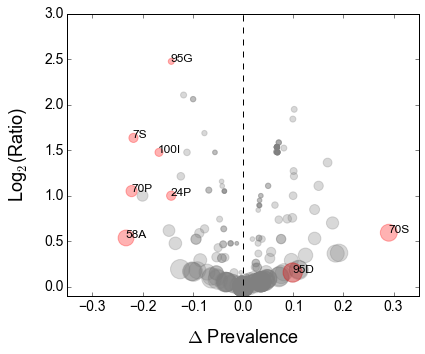

In [275]:
fig, ax = plt.subplots(figsize=(6,5))
sz = list(final_DF['Proportion'])
sz = [a*4 for a in sz]

color_list = []
for i,row in final_DF[['Position','Variant','Difference','Log2FC','Z']].iterrows():
    P = str(row.Position)
    V = str(row.Variant)
    D = row.Difference
    F = row.Log2FC
    Z = row.Z
    if abs(Z) >= 1.5:
        color_list.append('red')
        ax.annotate(P+V, [D, F], size=12)
    else:
        color_list.append('grey')

ax.scatter(final_DF['Difference'], final_DF['Log2FC'], color=color_list, alpha=0.3, s=sz)

ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel(r'$\Delta$ Prevalence', size=18, labelpad=15)
ax.set_ylabel(r'Log$_2$(Ratio)', size=18, labelpad=15)
ax.vlines(x=0,ymin=-10,ymax=10,linestyles='--')

ax.set_xlim([-0.35,0.35])
ax.set_ylim([-0.1,3])
plt.tight_layout()
plt.show()
savepath = '/Users/greg/Desktop/TatFigureStuff/Enrichment.png'
fig.savefig(savepath, format='png', dpi=300, bbox_inches='tight')